<a href="https://colab.research.google.com/github/NickMattiss/AIML_inlamning1/blob/main/AIML_inlamning1_NM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries
import sys
!{sys.executable} -m pip install numpy tensorflow
from IPython.display import clear_output
clear_output()
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Install and import wandb library
!pip install wandb
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 168 kB 42.7 MB/s 
     |████████████████████████████████| 182 kB 51.2 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 168 kB 47.0 MB/s 
     |████████████████████████████████| 166 kB 31.9 MB/s 
     |████████████████████████████████| 166 kB 44.9 MB/s 
     |████████████████████████████████| 162 kB 49.8 MB/s 
     |████████████████████████████████| 162 kB 14.3 MB/s 
     |████████████████████████████████| 158 kB 8.7 MB/s 
     |████████████████████████████████| 157 kB 49.6 MB/s 
     |████████████████████████████████| 157 kB 43.3 MB/s 
     |████████████████████████████████| 157 kB 49.4 MB/s 
     |████████████████████████████████| 157 kB 46.1 MB/s 
     |████████████████████████████████| 157 kB 44.6 MB/s 
     |█████████████████████████████

In [88]:
# Import the data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Prepare the data
x_train = x_train.astype("float32") / 255 # from integers to floats
x_test = x_test.astype("float32") / 255
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) # shape to 28*28
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
y_train = keras.utils.to_categorical(y_train, 10) # convert class vectors to binary, define no of classes
y_test = keras.utils.to_categorical(y_test, 10)

In [89]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [1]:
len(x_train), len(x_test)

NameError: ignored

In [90]:
# Define the cnn model
def create_cnn(input_shape, output_classes):
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(output_classes, activation="softmax"),
        ]
    )

In [91]:
# Compile the model
model = create_cnn((28, 28, 1), 10) # image shape, no of classes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [97]:
# Train the model
wandb.init(project="aiml_inlamning1_wandb") # wandb.login()
# wandb.log({"myparam": 100}, step=5)
batch_size = 1024
epochs = 10
model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, validation_split=0.1, 
          callbacks=[wandb.keras.WandbCallback()])
wandb.finish()

Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9936

wandb: Adding directory to artifact (/content/wandb/run-20221211_163406-14kdw249/files/model-best)... Done. 0.0s


53/53 [==============================] - 42s 790ms/step - loss: 0.0284 - accuracy: 0.9936 - val_loss: 0.4101 - val_accuracy: 0.9083
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9943

wandb: Adding directory to artifact (/content/wandb/run-20221211_163406-14kdw249/files/model-best)... Done. 0.0s


53/53 [==============================] - 42s 793ms/step - loss: 0.0274 - accuracy: 0.9943 - val_loss: 0.4082 - val_accuracy: 0.9097
Epoch 3/10
53/53 [==============================] - 41s 769ms/step - loss: 0.0271 - accuracy: 0.9943 - val_loss: 0.4085 - val_accuracy: 0.9100
Epoch 4/10
53/53 [==============================] - 41s 766ms/step - loss: 0.0262 - accuracy: 0.9951 - val_loss: 0.4121 - val_accuracy: 0.9090
Epoch 5/10
53/53 [==============================] - 42s 802ms/step - loss: 0.0263 - accuracy: 0.9946 - val_loss: 0.4149 - val_accuracy: 0.9075
Epoch 6/10
53/53 [==============================] - 41s 765ms/step - loss: 0.0259 - accuracy: 0.9950 - val_loss: 0.4150 - val_accuracy: 0.9080
Epoch 7/10
53/53 [==============================] - 41s 766ms/step - loss: 0.0259 - accuracy: 0.9950 - val_loss: 0.4180 - val_accuracy: 0.9087
Epoch 8/10
53/53 [==============================] - 40s 763ms/step - loss: 0.0255 - accuracy: 0.9949 - val_loss: 0.4222 - val_accuracy: 0.9100
Epoch 9/10

accuracy,▁▄▄█▆██▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▄▄▃▃▂▁▁
val_accuracy,▃▆▇▄▁▂▄▇▄█
val_loss,▂▁▁▃▄▄▆█▇█
accuracy,0.99507
best_epoch,1
best_val_loss,0.40817
epoch,9
loss,0.02475
val_accuracy,0.91067


In [ ]:
# PREPROCESS WITH WANDB

In [1]:
# Import packages
# import sys
# !{sys.executable} -m pip install numpy tensorflow wandb
# import wandb
# import numpy as np
# from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
from datetime import datetime
date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

wandb_run = wandb.init(project="aiml_inlamning1_wandb", name=f"preprocessing {date_and_time}")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
# Download the data

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
# Define histograms

def log_bar(x, y, title, x_name="x", y_name="y", keep_order=False):
    if keep_order:
        x = [f"{idx}: {x_}" for idx, x_ in enumerate(x)] # Make sure alphabetical sorting works
    table = wandb.Table(
        data=[[x, y] for x, y in zip(x, y)],
        columns=[x_name, y_name]
    )
    wandb.log({title: wandb.plot.bar(table, x_name, y_name, title=title)})


def create_histogram(data, min_value=None, max_value=None, bins=10):
    if min_value is None:
        min_value = data.min()
    if max_value is None:
        max_value = data.max()

    if isinstance(bins, int):
        bin_edges = np.linspace(min_value, max_value, num=bins)
    else:
        bin_edges = bins
        
    numbers, _ = np.histogram(data, bins=bin_edges)
    bin_names = [f"{lower:.1f}-{upper:.1f}" for lower, upper in zip(bin_edges[:-1], bin_edges[1:])]

    return bin_names, numbers

In [8]:
# Visualize labels

from collections import Counter

num_images_per_label = Counter(y_train)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in training data", x_name="Label", y_name="# images")

num_images_per_label = Counter(y_test)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in test data", x_name="Label", y_name="# images")

In [9]:
print(num_images_per_label)

Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


Sample 27 is a pullover


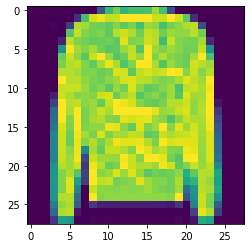

In [10]:
# Visualize training data
dict = {0:'t-shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}
i = 27
print(f"Sample {i} is a {dict[y_train[i]]}")
plt.imshow(x_train[i])

image = wandb.Image(x_train[i], caption=f"Training sample {i} is a {dict[y_train[i]]}")
wandb.log({"Example training image": image})

In [11]:
# Log the datasets minimum and maximum intensities and datatype to the WandB summary
min_value = min(x_train.min(), x_test.min())
max_value = max(x_train.max(), x_test.max())
wandb_run.summary["raw"] = {"min": min_value, "max": max_value, "dtype": str(x_train.dtype)}

# Create a new histogram of the image pixels intensities
bin_names, train_hist = create_histogram(x_train)
log_bar(bin_names, train_hist, "Raw training data", x_name="bin", y_name="# pixels", keep_order=True)

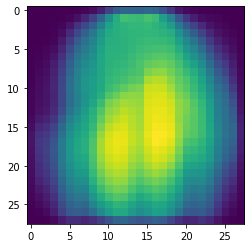

In [12]:
# Create a heatmap over all active pixels from all frames
heatmap = np.mean(x_train, axis=0)
plt.imshow(heatmap)
wandb.log({"Heatmap of training images": wandb.Image(np.expand_dims(heatmap, axis=2), caption="The mean of all images in the training set")})

# Log a histogram of the average value for each pixel through out the
# training dataset. This shows us how many of the pixels that are
# always zero in all frames.
bin_names, heatmap_hist = create_histogram(heatmap.flatten(), bins=[0, 1, 10, 30, 100, 255])
log_bar(bin_names, heatmap_hist, "Average value per pixel in training data", x_name="bin", y_name="# pixels", keep_order=True)

In [13]:
# Preprocess the data
# Normalize the values to the range -1...1
x_train_norm = x_train / 128 - 1
x_test_norm = x_test / 128 - 1

In [14]:
# Create a new histogram of the modified values
min_value = min(x_train_norm.min(), x_test_norm.min())
max_value = max(x_train_norm.max(), x_test_norm.max())
wandb_run.summary["preprocessed"] = {"min": min_value, "max": max_value, "dtype": str(x_train_norm.dtype)}

bin_names, train_hist = create_histogram(x_train_norm)
log_bar(bin_names, train_hist, "Preprocessed training data", x_name="bin", y_name="# pixels", keep_order=True)

Sample 68 is a coat


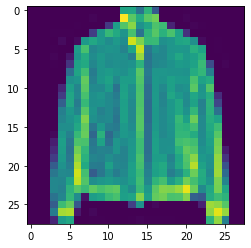

In [15]:
# Visualize training data
dict = {0:'t-shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}
i = 68
print(f"Sample {i} is a {dict[y_train[i]]}")
plt.imshow(x_train[i])

image = wandb.Image(x_train[i], caption=f"Training sample {i} is a {dict[y_train[i]]}")
wandb.log({"Example training image": image})

In [16]:
# Sample test data
num_images_per_label = Counter(y_test)
min_number_of_labels = min(num_images_per_label.values())

indexes_to_keep = []
for label in num_images_per_label.keys():
  indexes_to_keep.extend(
      np.random.choice(
          np.where(y_test == label)[0],
          size=min_number_of_labels,
          replace=False
      ).tolist()
  )

np.random.shuffle(indexes_to_keep)
x_test_norm_subsamp = x_test_norm[indexes_to_keep]
y_test_subsamp = y_test[indexes_to_keep]

In [17]:
x_test_norm_subsamp.shape

(10000, 28, 28)

This should be a coat


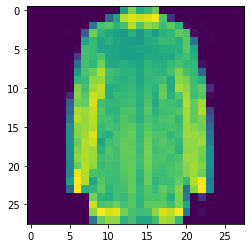

In [18]:
# Verify that the labels and images are still in sync
dict = {0:'t-shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}
print(f"This should be a {dict[y_test_subsamp[0]]}")
plt.imshow(x_test_norm_subsamp[0])

In [19]:
# Log the new distribution
num_images_per_label = Counter(y_test_subsamp)
labels_, num_images = zip(*((str(label), number) for label, number in sorted(num_images_per_label.items())))
log_bar(labels_, num_images, "Labels in test data (subsampled)", x_name="Label", y_name="# images")

In [ ]:
#from sklearn import metrics
#predicted = model.predict(x_test[0:10])
#print(predicted)
#print(metrics.classification_report(y_test, predicted))
#metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
#print(metrics.classification_report(predicted))
#metrics.ConfusionMatrixDisplay.from_predictions(predicted)

1/1 [==============================] - 0s 23ms/step
[[3.1784256e-17 8.5566025e-34 5.5166007e-18 5.5961876e-19 9.5221443e-22
  2.2540620e-12 2.2410784e-22 2.7163381e-07 4.7454011e-12 9.9999970e-01]
 [1.4266743e-03 3.3902653e-27 9.9848807e-01 7.8309240e-05 5.1106852e-08
  2.3229358e-23 6.8576819e-06 0.0000000e+00 2.6024449e-14 2.4062588e-28]
 [2.5330197e-16 9.9999994e-01 2.9346422e-19 1.0199472e-18 3.7606968e-22
  2.0764215e-19 4.7588627e-23 0.0000000e+00 6.9752368e-25 9.0939160e-33]
 [9.8598546e-22 9.9999994e-01 3.9277914e-28 2.4989340e-20 8.5112680e-24
  4.2563931e-21 1.6456723e-24 1.8583582e-38 5.9043878e-30 1.8167817e-34]
 [4.3413602e-03 1.0684595e-16 2.3680745e-05 2.1988480e-09 7.0404296e-04
  1.7444930e-23 9.9493080e-01 2.2265812e-23 2.8290709e-19 1.0933585e-25]
 [7.4175436e-17 9.9999994e-01 3.0190094e-19 8.6666709e-15 1.1734829e-24
  2.4125954e-22 4.7861464e-18 0.0000000e+00 3.8084322e-18 3.2959862e-33]
 [6.2071046e-09 1.4015144e-15 5.6691165e-04 5.1310377e-07 9.7741121e-01
  9.46